# FRCNN Dataset 6 Test

In [1]:
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import skimage.draw
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath('/notebooks/WhatRThose/FPN_F_RCNN/FPN_FRCNN_master/')
sys.path.append(ROOT_DIR)  # To find local version of the library

# Import Faster RCNN
import WhatRThose_config 
import frcnn.model_ks as modellib 
from frcnn import utils, visualize
from frcnn.config import Config

Using TensorFlow backend.


## Update PATHS

In [2]:
TEST_DIR_TRAIN = "/notebooks/WhatRThose/data/annotation_train.csv"
TEST_DIR_VAL = "/notebooks/WhatRThose/data/annotation_val.csv"
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
IMNET_MODEL_PATH = os.path.join(ROOT_DIR, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

## Load Image Dataset

**<font color ='green'>Change class from `BMW_config` to correct configuration class when testing different datasets</font>**

In [3]:
config = WhatRThose_config.run1()

In [4]:
# Load Train dataset
dataset_train = WhatRThose_config.Dataset()
dataset_train.load_data(TEST_DIR_TRAIN,"train")
dataset_train.prepare()

# Load Val dataset
dataset_val = WhatRThose_config.Dataset()
dataset_val.load_data(TEST_DIR_VAL,"val")
dataset_val.prepare()

Parsing annotation train files
406 train files
Parsing annotation val files
22 val files


## Batch Size

**<font color='green'>Overide config Batch size for testing</font>**

In [5]:
overide = True 
if overide:
    config.BATCH_SIZE = 2
    config.IMAGES_PER_GPU = 2
    config.STEPS_PER_EPOCH = np.ceil(len(dataset_train.image_info)/config.BATCH_SIZE)

print('Batch Size: {}'.format(config.BATCH_SIZE))
print('Steps per Epoch: {}'.format(config.STEPS_PER_EPOCH))
print('Steps per Epoch equals train files divided by batch size: {}'\
      .format(np.ceil(len(dataset_train.image_info)/config.BATCH_SIZE) == config.STEPS_PER_EPOCH))

Batch Size: 2
Steps per Epoch: 203.0
Steps per Epoch equals train files divided by batch size: True


## Creating the Model

In [6]:
# Create model in training mode
model = modellib.FasterRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [7]:
model.load_weights(COCO_MODEL_PATH, by_name=True,
                   exclude=["frcnn_class_logits", "frcnn_bbox_fc","frcnn_bbox"])

## Training 

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Stage 1

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE, 
            epochs=5, 
            layers='heads',
            )


Starting at epoch 0. LR=0.001

Checkpoint Path: /notebooks/WhatRThose/FPN_F_RCNN/FPN_FRCNN_master/logs/test620190407T1632/FASTER_RCNN_test6_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
FRCNN_class_conv1      (TimeDistributed)
FRCNN_class_bn1        (TimeDistributed)
FRCNN_class_conv2      (TimeDistributed)
FRCNN_class_bn2        (TimeDistributed)
FRCNN_bbox_fc          (TimeDistributed)
FRCNN_class_logits     (TimeDistributed)


/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
203/203 [==============================] - 218s 1s/step - loss: 0.5049 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.1699 - FRCNN_class_loss: 0.1363 - FRCNN_bbox_loss: 0.1852 - val_loss: 2.9941 - val_rpn_class_loss: 0.0374 - val_rpn_bbox_loss: 0.4169 - val_FRCNN_class_loss: 1.7125 - val_FRCNN_bbox_loss: 0.8273
Epoch 2/5
203/203 [==============================] - 212s 1s/step - loss: 0.1390 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0159 - FRCNN_class_loss: 0.0565 - FRCNN_bbox_loss: 0.0656 - val_loss: 2.6528 - val_rpn_class_loss: 0.0373 - val_rpn_bbox_loss: 0.3751 - val_FRCNN_class_loss: 1.5044 - val_FRCNN_bbox_loss: 0.7361
Epoch 3/5
203/203 [==============================] - 212s 1s/step - loss: 0.0675 - rpn_class_loss: 3.7501e-04 - rpn_bbox_loss: 0.0037 - FRCNN_class_loss: 0.0274 - FRCNN_bbox_loss: 0.0360 - val_loss: 2.8169 - val_rpn_class_loss: 0.0339 - val_rpn_bbox_loss: 0.3780 - val_FRCNN_class_loss: 1.7551 - val_FRCNN_bbox_loss: 0.6499
Epoch 4/5
203/203 [=================

In [9]:
train_loss = model.keras_model.history.history['loss']
val_loss = model.keras_model.history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (10,) and (5,)

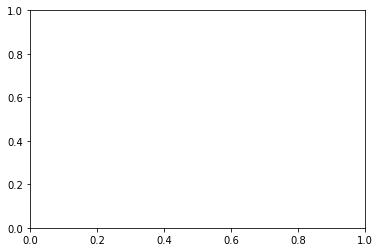

In [10]:
plt.plot(np.arange(1,11),train_loss, color='blue',label='train_loss')
plt.plot(np.arange(1,11),val_loss, color='red',label='val_loss')
plt.legend()

### Stage 2

In [9]:
# # Fine tune all layers
# # Passing layers="all" trains all layers. You can also 
# # pass a regular expression to select which layers to
# # train by name pattern.
# model.train(dataset_train, dataset_val, 
#             learning_rate=config.LEARNING_RATE / 10,
#             epochs=20, 
#             layers="all")

## Detection

In [12]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

**<font color='green'> Change inherited class to correct dataset </font>**

In [13]:
class InferenceConfig(WhatRThose_config.run1):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.FasterRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /notebooks/WhatRThose/FPN_RCNN/FPN_FRCNN_master/logs/test6_batch820190325T1457/FASTER_RCNN_test6_batch8_0020.h5


### Ground Truth Image

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  float64
gt_class_id              shape: (2,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (2, 4)                min:  172.88889  max:  837.84615  float64


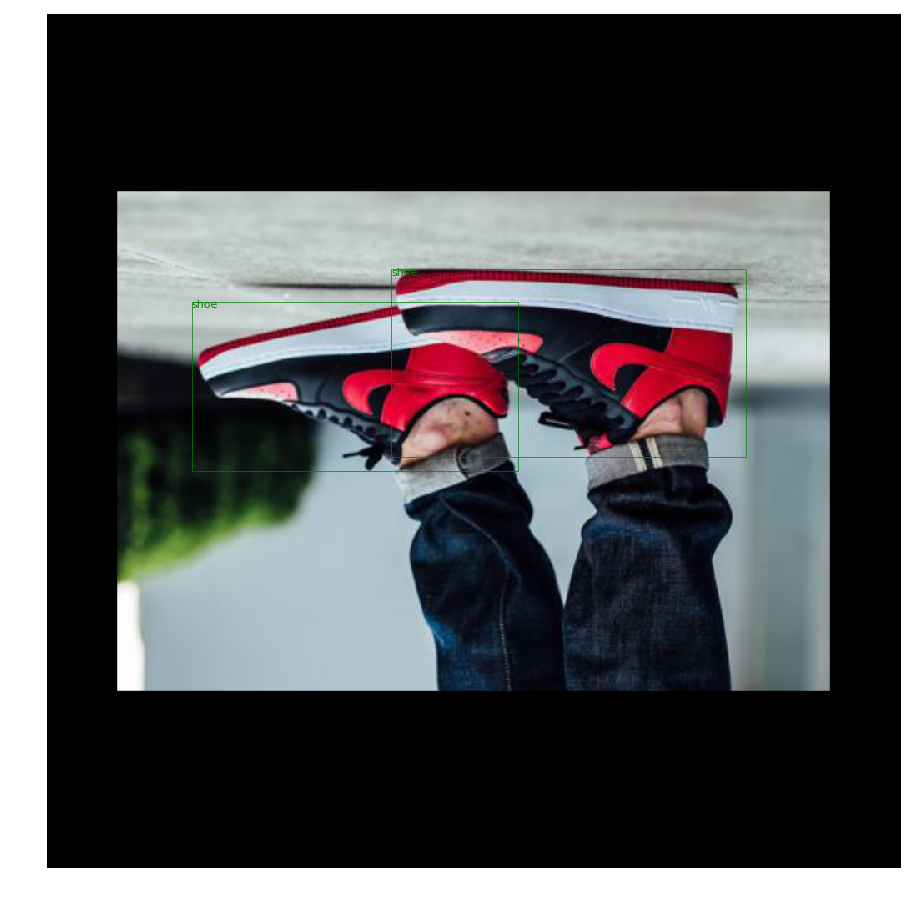

In [14]:
# Test on a random image
image_ids = np.random.choice(dataset_train.image_ids,1)

for image_id in image_ids:
    original_image, image_meta, gt_class_id, gt_bbox =\
        modellib.load_image_gt(dataset_train, inference_config, 
                               image_id)

    modellib.log("original_image", original_image)
    modellib.log("image_meta", image_meta)
    modellib.log("gt_class_id", gt_class_id)
    modellib.log("gt_bbox", gt_bbox)

    visualize.display_instances(original_image, gt_bbox, gt_class_id, 
                                dataset_train.class_names, figsize=(16, 16))

### Validation Prediction Image

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.70780  max:    1.64524  float32

*** No instances to display *** 



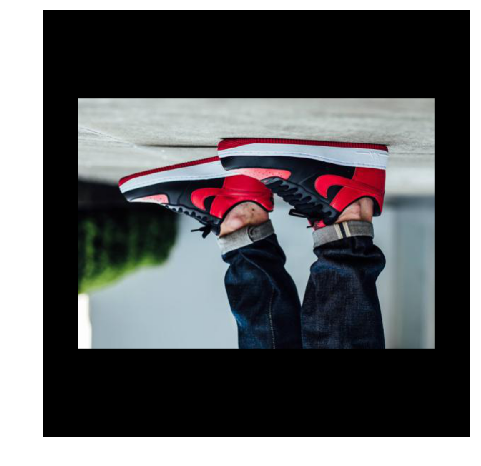

In [15]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['class_ids'], 
                            dataset_train.class_names, r['scores'], ax=get_ax())

## Val mAP

In [14]:
# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = dataset_val.image_ids
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox =\
#         modellib.load_image_gt(dataset_val, inference_config,
#                                image_id)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id,
#                          r["rois"], r["class_ids"], r["scores"])
#     APs.append(AP)
    
# print("mAP: ", np.mean(APs))